In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

In [24]:
df_clean = pd.read_csv("Dataset/clean_df.csv")
df_clean.head()

,Unnamed: 0,id_tracks,name_tracks,popularity_tracks,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,id_artists,followers,genres,name_artists,popularity_artists,year,month,day,dayofweek,weekofyear,duration_ms_log
0,56,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,0,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.212,0.457,130.418,5,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,21,1,12,12.109782
1,57,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,0,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.104,0.397,169.980,3,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,21,1,12,12.083379
2,58,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,0,0.548,0.0391,6,-23.228,1,0.1530,0.996,0.933000,0.148,0.612,75.595,3,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,29,2,13,12.107208
3,59,0l3BQsVJ7F76wlN5QhJzaP,El Vendaval - Remasterizado,0,0,0.370,0.3720,2,-17.138,1,0.0865,0.985,0.000681,0.929,0.753,159.669,4,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,21,1,12,11.941671
4,60,0xJCJ9XSNcdTIz0QKmhtEn,La Maleva - Remasterizado,0,0,0.339,0.0958,8,-26.944,1,0.0530,0.994,0.969000,0.123,0.219,86.279,3,5LiOoJbxVSAMkBS2fUm3X2,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,29,2,13,12.108680


In [25]:
df_clean.sort_values(by = ["year","month","day"], inplace = True)
df_clean.drop_duplicates(subset = ["name_tracks","name_artists"], keep = 'last', inplace=True, ignore_index=True)

# Based on the distribution of track popularity, I suspect many cases with popularity 0 are missing value. By looking up
# some cases on Spotify, I think my suspecion might be true.

df_clean = df_clean[df_clean.popularity_tracks!=0]

In [26]:
# Map id and name of artists to a single numerical id
unique_artists = df_clean[['name_artists', 'id_artists']].drop_duplicates()
artist_ids, unique_values = pd.factorize(unique_artists['id_artists'])
unique_artists['artist_num_id'] = artist_ids
df_clean = pd.merge(df_clean, unique_artists[['name_artists', 'artist_num_id']], 
                    on='name_artists', how='left')

# Drop unused columns 
dropped_columns = ['Unnamed: 0','id_tracks','name_tracks','id_artists','name_artists']
df_clean = df_clean.drop(columns=dropped_columns)

In [27]:
# Transform the string of genres to a tuple
def genre_transform (genre_string):
  genre_list = genre_string.split(", ")
  genre_list = [s.strip("'") for s in genre_list]
  return tuple(genre_list)

df_clean['genres'] = df_clean['genres'].apply(genre_transform)

# Print the number of genres
all_genres = np.unique(np.concatenate(df_clean["genres"].values))
print("There are "+str(len(all_genres))+" different genres in the dataset.")

# Do a target encoding on each tuple of genres
encoder = TargetEncoder(cols=["genres"])
df_target = df_clean['popularity_artists']
encoder.fit(df_clean, df_target)
df_clean = encoder.transform(df_clean)

There are 4334 different genres in the dataset.


C:\Users\XMhua\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\XMhua\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [28]:
bins = [0, 10, 20, 30, 40, 50, 60, 100]
group_name = [i for i in range(0,7)]
df_clean['popularity_score'] = pd.cut(df_clean.popularity_tracks, bins = bins, labels = group_name)
df_clean.drop(axis=1, labels = "popularity_tracks", inplace = True)

In [29]:
pd.set_option('display.max_columns', None)
df_clean.head()

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,popularity_artists,year,month,day,dayofweek,weekofyear,duration_ms_log,artist_num_id,popularity_score
0,0,0.659,0.7910,2,-4.895,1,0.0295,0.139,0.000002,0.161,0.956,141.999,4,21048.0,40.347826,49,1900,1,1,0,1,12.362734,0,1
1,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,23.673469,2,1921,1,1,6,52,12.105147,1,0
2,0,0.537,0.0443,3,-16.474,0,0.0343,0.996,0.000265,0.152,0.137,80.468,4,116265.0,44.000000,44,1923,1,1,0,1,12.238540,2,2
3,0,0.709,0.0620,5,-12.207,1,0.0480,0.995,0.003410,0.120,0.553,85.854,4,116265.0,44.000000,44,1923,1,1,0,1,12.107208,2,2
4,0,0.693,0.0270,0,-13.506,0,0.0562,0.992,0.000000,0.134,0.402,75.749,4,116265.0,44.000000,44,1923,1,1,0,1,12.029574,2,2


In [30]:
num_features = ['duration_ms_log', 'explicit', 'danceability', 'energy', 'key',
                'loudness', 'mode', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo',
                'time_signature', 'followers', 'popularity_artists', 'year',
               'month', 'day', 'dayofweek', 'weekofyear', 'artist_num_id', 
                'genres']
target = ['popularity_score']

Highly correlated pairs = [('popularity_artists', 'genres')]


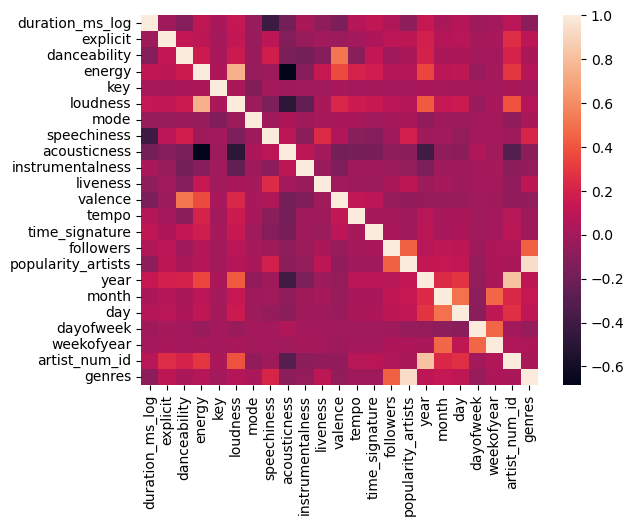

In [31]:
df_X = df_clean[num_features]
corr = df_X.corr()
sns.heatmap(corr)

#Find the pairs of features correlated above 0.9
corr_column_names = corr.columns
highly_correlated_pairs = []

for i in range (0,len(corr_column_names)):
    corr_column_name = corr_column_names[i]
    corr_column_values = corr[corr_column_name].values
    for j in range (i,len(corr_column_values)):
        if (i!=j) and (abs(corr_column_values[j]) >= 0.9):
            highly_correlated_pairs.append((corr_column_names[i],corr_column_names[j]))

print("Highly correlated pairs = "+str(highly_correlated_pairs))


In [39]:
# There are not many tracks with popularity greater than 60, 
# so I combine them into one group.

df_clean[target].value_counts()

popularity_score
2                   84130
3                   82820
1                   64238
4                   55342
0                   47226
5                   28783
6                   12720
dtype: int64

In [40]:
df_X.shape

(375259, 23)

In [41]:
num_classes = 7
y = keras.utils.to_categorical(np.array(df_clean[target]).reshape(-1),
                               num_classes)
x = df_X
x_dev, x_test, y_dev, y_test = train_test_split(x,y, test_size = 0.2,
                                               stratify= y)

In [42]:
# Standardize dataset x
scaler = StandardScaler()
x_dev_st = scaler.fit_transform(x_dev)
x_test_st = scaler.transform(x_test)

# split development set into train and validation sets

x_train, x_val, y_train, y_val = train_test_split(x_dev_st, y_dev,
                                                 test_size = 0.2, stratify = y_dev
                                                 )

Build a neural network

Hidden layer size - 15

Output layer size - 7

In [43]:
model = keras.Sequential([
    keras.Input(shape=(23,)),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(7, activation='softmax')
])

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 15)                360       
                                                                 
 dense_7 (Dense)             (None, 7)                 112       
                                                                 
Total params: 472
Trainable params: 472
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer= "adam", loss="categorical_crossentropy",
 metrics=["CategoricalAccuracy"])
history = model.fit(x_train, y_train, batch_size= 64, epochs=15, verbose=1,
 validation_data = (x_val, y_val))

Epoch 1/15
3753/3753 [==============================] - 4s 901us/step - loss: 1.3600 - categorical_accuracy: 0.4159 - val_loss: 1.3575 - val_categorical_accuracy: 0.4155
Epoch 2/15
3753/3753 [==============================] - 3s 858us/step - loss: 1.3596 - categorical_accuracy: 0.4158 - val_loss: 1.3562 - val_categorical_accuracy: 0.4167
Epoch 3/15
3753/3753 [==============================] - 3s 850us/step - loss: 1.3593 - categorical_accuracy: 0.4158 - val_loss: 1.3559 - val_categorical_accuracy: 0.4154
Epoch 4/15
3753/3753 [==============================] - 3s 866us/step - loss: 1.3590 - categorical_accuracy: 0.4168 - val_loss: 1.3566 - val_categorical_accuracy: 0.4139
Epoch 5/15
3753/3753 [==============================] - 3s 878us/step - loss: 1.3589 - categorical_accuracy: 0.4163 - val_loss: 1.3552 - val_categorical_accuracy: 0.4177
Epoch 6/15
3753/3753 [==============================] - 3s 855us/step - loss: 1.3586 - categorical_accuracy: 0.4167 - val_loss: 1.3545 - val_categoric